In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import sklearn as sk
import pickle
import optiver2023

pd.set_option("display.max_colwidth", 20)
pd.set_option("display.precision", 3)
DATA_DIR = "/kaggle/input/optiver-trading-at-the-close/"
plt.rcParams['figure.dpi'] = 270

In [2]:
# Read the data
Xy_Train = pd.read_csv(DATA_DIR + "train.csv")
Xy_Train.head(5)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3.181e+06,1,1.0,1.338e+07,NaN,NaN,1.000,60651.50,1.000,8493.03,1.0,-3.03,0,0_0_0
1,1,0,0,1.666e+05,-1,1.0,1.642e+06,NaN,NaN,1.000,3233.04,1.001,20605.09,1.0,-5.52,0,0_0_1
2,2,0,0,3.029e+05,-1,1.0,1.819e+06,NaN,NaN,0.999,37956.00,1.000,18995.00,1.0,-8.39,0,0_0_2
3,3,0,0,1.192e+07,-1,1.0,1.839e+07,NaN,NaN,1.000,2324.90,1.000,479032.40,1.0,-4.01,0,0_0_3
4,4,0,0,4.475e+05,-1,1.0,1.786e+07,NaN,NaN,0.999,16485.54,1.000,434.10,1.0,-7.35,0,0_0_4


# 1. Exploratory data analysis

In [3]:
# Show the basic information of the features
def inspect_columns(df):
    # Copy the helper function
    result = pd.DataFrame({
        "count": df.count(),
        "unique": df.nunique() == len(df),
        "cardinality": df.nunique(),
        "with_nan": df.isna().any(),
        "null_pct": round((df.isnull().sum() / len(df)) ** 100, 2),
        "1st_row": df.iloc[0],
        "last_row": df.iloc[-1],
        "dtype": df.dtypes,
    })
    return result

In [4]:
inspect_columns(Xy_Train)

,count,unique,cardinality,with_nan,null_pct,1st_row,last_row,dtype
stock_id,5237980,False,200,False,0.0,0,199,int64
date_id,5237980,False,481,False,0.0,0,480,int64
seconds_in_bucket,5237980,False,55,False,0.0,0,540,int64
imbalance_size,5237760,False,2971863,True,0.0,3180602.69,1884285.71,float64
imbalance_buy_sell_flag,5237980,False,3,False,0.0,1,-1,int64
reference_price,5237760,False,28741,True,0.0,1.0,1.002,float64
matched_size,5237760,False,2948862,True,0.0,13380276.64,24073677.32,float64
far_price,2343638,False,95739,True,0.0,NaN,1.001,float64
near_price,2380800,False,84625,True,0.0,NaN,1.001,float64
bid_price,5237760,False,28313,True,0.0,1.0,1.002,float64


- Common Indicators (Features)
    - stock_id: 股票的唯一代码，有200只股票
    - date_id: 交易日的唯一代码，有3个交易日
    - seconds_in_bucket: 日内交易时间的唯一代码，日内有55个seconds_buckets，0，10，20，...，540，根据题目意思这个应该是最后10min中的时间，单位是s，最后60s没有是因为其没有target。
    - row_id: 每个样本的编号，组成应该为 {date_id}-{seconds_in_bucket}-{stock_id}
    - time_id: 每个日期和日内时间组成的标识，$3 \times 55 = 165$
    - target: 预测的目标

- OrderBook Indicators
    - bid_price: 最优买价，目前优先级最高的等待买入成交的价格
    - ask_price: 最优卖价，目前优先级最高的等待卖出成交的价格
    - bid_size: 最优买价下对应的等待成交的数量
    - ask_size: 最优卖价下对应的等待成交的数量
    - wap: bid_price和ask_price的加权价格，公式如下：
    $$
    WAP = \frac{\text{ask_price} \times \text{bid_size} + \text{bid_price} \times \text{ask_size}}{\text{bid_size} + \text{ask_size}}
    $$
    由此可见，$WAP\in [\text{bid_price}, \text{ask_price}]$，并且如果买单量较大，说明买压较强，最终的均价应该在靠近卖价的位置；卖单量较大则相反。

- Auction Indicators
    - far_price: 在拍卖订单簿中，最优成交量对应的价格
- Combined Indicators
    - near_price: 合并连续竞价订单簿和拍卖订单簿后，总订单簿中最优成交量对应的价格
    - reference_price: 三种情况如下所示，总结来说就是三者的中值
    $$
    \begin{array}
        \text{\text{near_price}},\quad \text{best bid_price} \le \text{near_price} \le \text{best ask_price} \\
        \text{best bid_price},\quad \text{near_price} \le \text{best bid_price}  \le \text{best ask_price} \\ 
        \text{best ask_price},\quad  \text{best bid_price}  \le \text{best ask_price}\le   \text{near_price}
    \end{array}
    $$
    - matched_size: 在reference_price价格下可以成交的最大数量
    - imbalance_size: 在reference_price价格下bid或ask方向价格满足可以成交但是没有成交的数量
    - imbalance_buy_sell_flag: 在reference_price价格下bid或ask方向价格满足可以成交但是没有成交的方向，+1代表buy，-1代表sell
    

In [5]:
def GetData(data, stock_id, date_id, n):
    # 观测具体的股票在某一天的数据情况
    return (data
            .query(f"stock_id == {stock_id} & date_id == {date_id}")
            .head(n)
    )

GetData(Xy_Train, 6, 2, 10)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
21016,6,2,0,1.491e+06,1,1.000,4.787e+06,NaN,NaN,0.999,8760.96,1.000,4384.08,1.000,13.15,110,2_0_6
21207,6,2,10,8.201e+05,1,1.001,5.458e+06,NaN,NaN,0.999,28717.66,1.001,2436.70,1.001,4.68,111,2_10_6
21398,6,2,20,8.201e+05,1,1.001,5.458e+06,NaN,NaN,1.000,9737.80,1.001,2436.70,1.001,1.01,112,2_20_6
21589,6,2,30,8.430e+05,1,1.001,5.458e+06,NaN,NaN,1.000,9737.80,1.001,2436.70,1.001,-0.47,113,2_30_6
21780,6,2,40,8.430e+05,1,1.001,5.458e+06,NaN,NaN,1.000,15098.86,1.001,2436.70,1.001,-1.49,114,2_40_6
21971,6,2,50,8.430e+05,1,1.001,5.458e+06,NaN,NaN,1.000,11689.44,1.001,2437.30,1.001,-3.89,115,2_50_6
22162,6,2,60,8.430e+05,1,1.001,5.458e+06,NaN,NaN,1.000,11689.44,1.001,2437.40,1.001,-10.41,116,2_60_6
22353,6,2,70,8.430e+05,1,1.001,5.458e+06,NaN,NaN,1.000,30685.41,1.001,1949.28,1.001,-8.51,117,2_70_6
22544,6,2,80,7.261e+05,1,1.000,5.575e+06,NaN,NaN,1.000,11689.44,1.000,9742.80,1.000,-3.67,118,2_80_6
22735,6,2,90,7.081e+05,1,1.000,5.593e+06,NaN,NaN,1.000,11689.44,1.000,9742.80,1.000,-3.51,119,2_90_6


In [6]:
# Get statistical info
Xy_Train.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,2.344e+06,2.381e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06,5.238e+06
mean,9.929e+01,2.415e+02,2.700e+02,5.715e+06,-1.190e-02,1.000e+00,4.510e+07,1.002e+00,9.997e-01,9.997e-01,5.181e+04,1.000e+00,5.358e+04,1.000e+00,-4.756e-02,1.331e+04
std,5.787e+01,1.385e+02,1.587e+02,2.052e+07,8.853e-01,2.532e-03,1.398e+08,7.215e-01,1.217e-02,2.499e-03,1.114e+05,2.510e-03,1.294e+05,2.498e-03,9.453e+00,7.619e+03
min,0.000e+00,0.000e+00,0.000e+00,0.000e+00,-1.000e+00,9.353e-01,4.317e+03,7.700e-05,7.870e-01,9.349e-01,0.000e+00,9.398e-01,0.000e+00,9.380e-01,-3.853e+02,0.000e+00
25%,4.900e+01,1.220e+02,1.300e+02,8.453e+04,-1.000e+00,9.988e-01,5.280e+06,9.963e-01,9.971e-01,9.985e-01,7.375e+03,9.990e-01,7.824e+03,9.988e-01,-4.560e+00,6.729e+03
50%,9.900e+01,2.420e+02,2.700e+02,1.114e+06,0.000e+00,1.000e+00,1.288e+07,9.999e-01,9.999e-01,9.997e-01,2.197e+04,1.000e+00,2.302e+04,1.000e+00,-6.020e-02,1.334e+04
75%,1.490e+02,3.610e+02,4.100e+02,4.191e+06,1.000e+00,1.001e+00,3.270e+07,1.003e+00,1.003e+00,1.001e+00,5.583e+04,1.001e+00,5.788e+04,1.001e+00,4.410e+00,1.991e+04
max,1.990e+02,4.800e+02,5.400e+02,2.982e+09,1.000e+00,1.077e+00,7.714e+09,4.380e+02,1.310e+00,1.077e+00,3.029e+07,1.078e+00,5.440e+07,1.078e+00,4.461e+02,2.645e+04


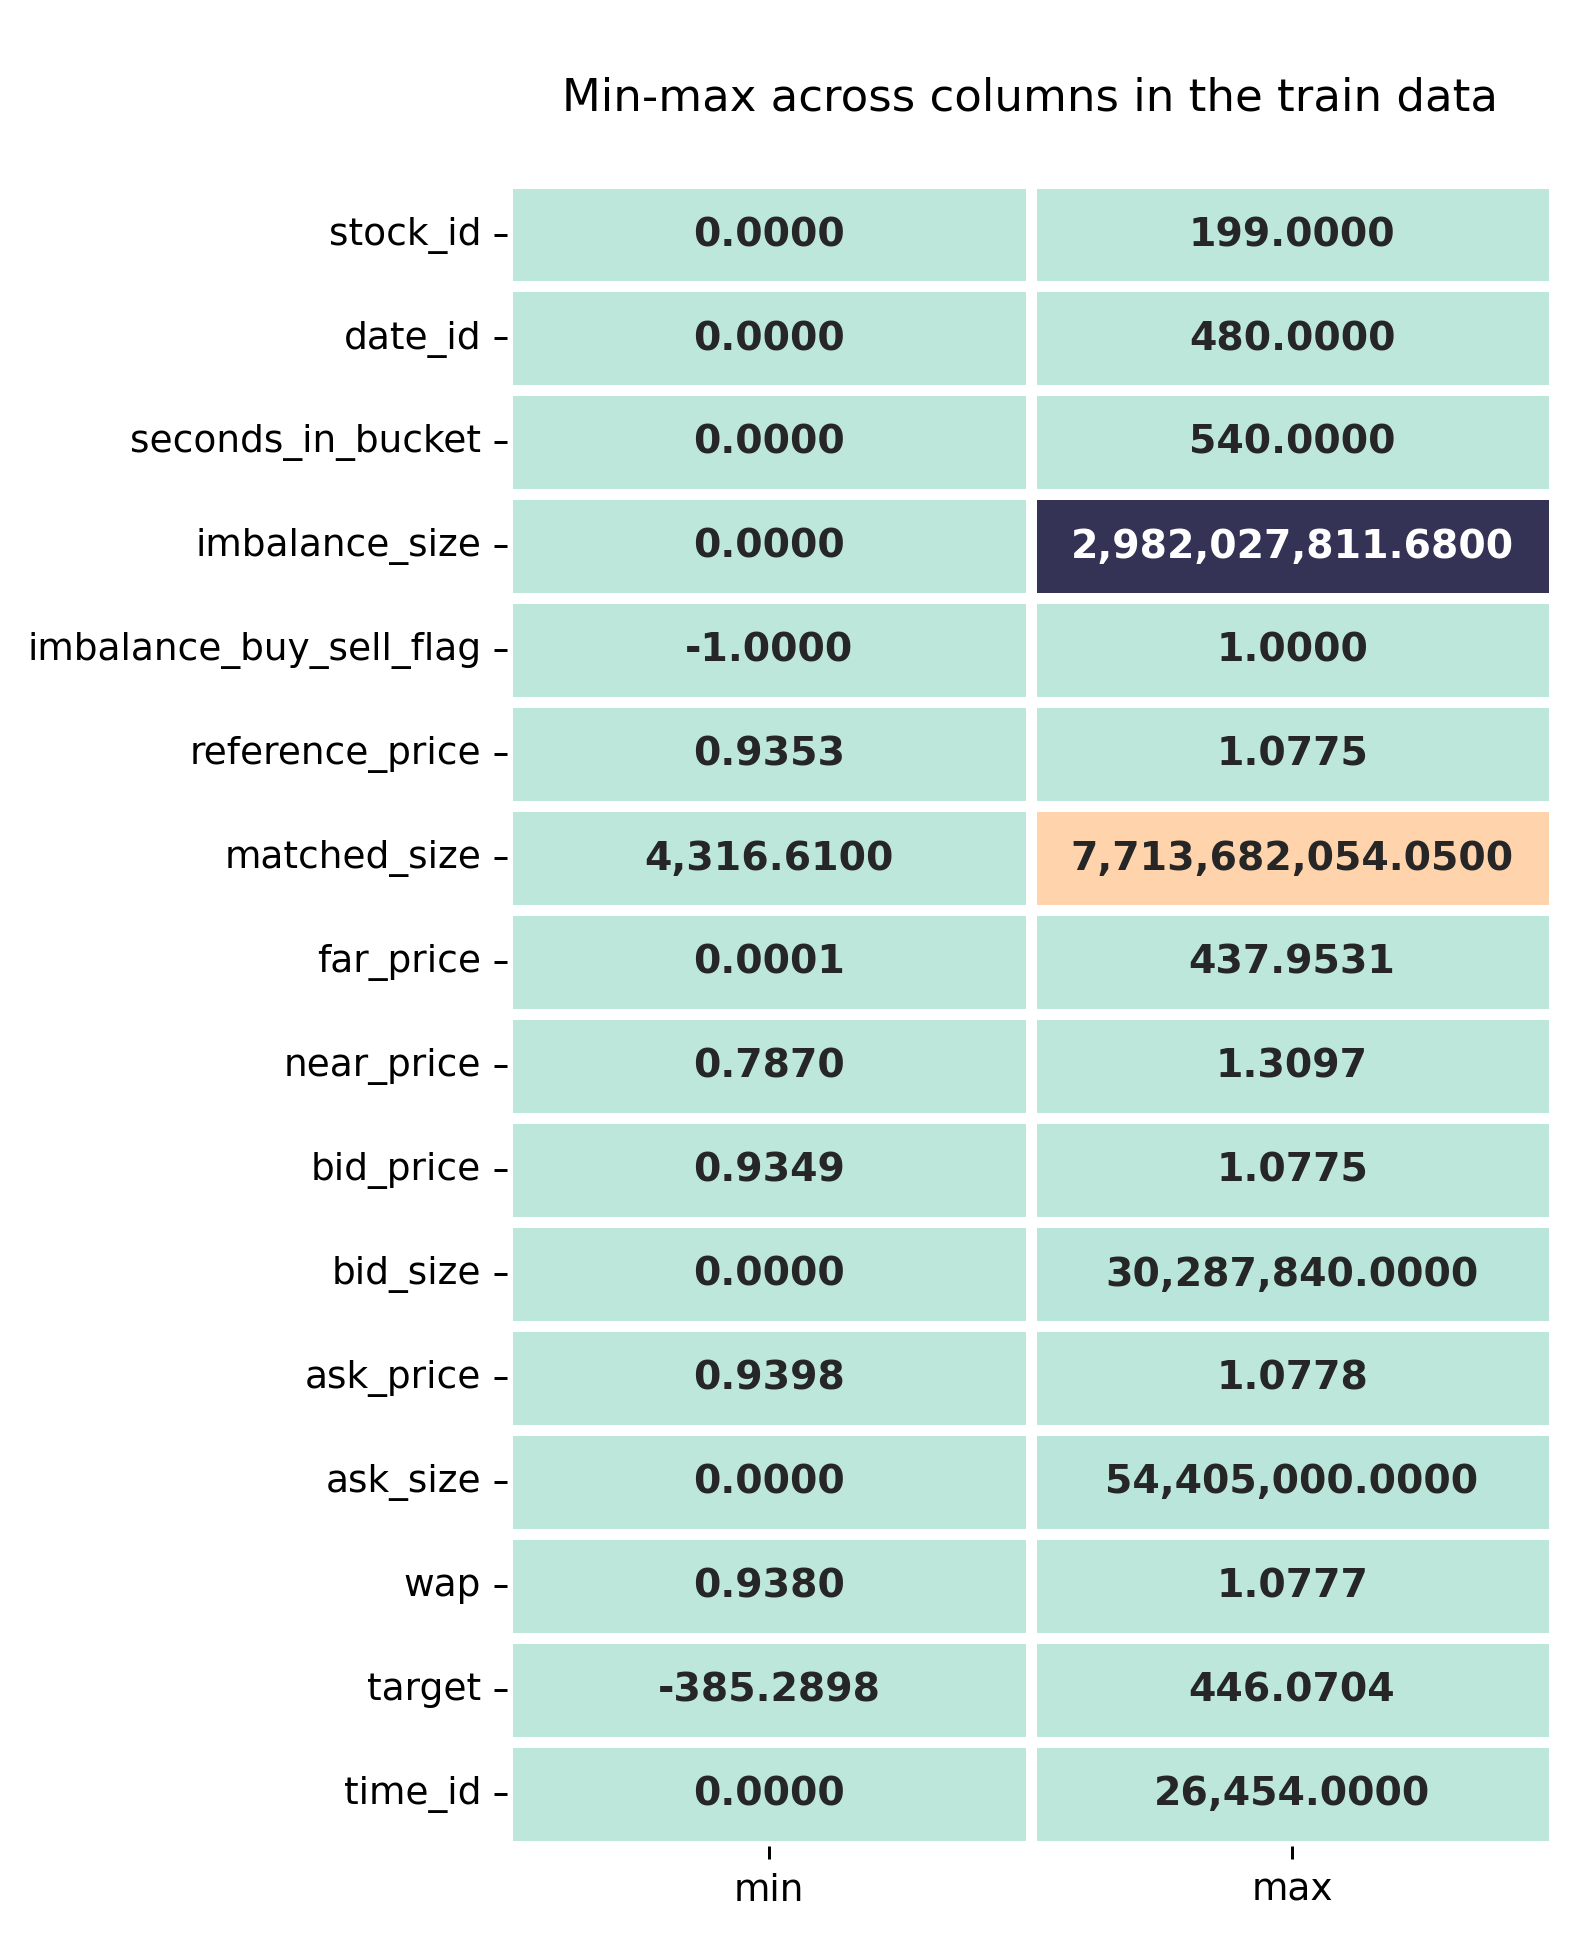

In [7]:
fig, ax = plt.subplots(1,1, figsize = (5, 8))
sns.heatmap(Xy_Train.describe().loc[['min', 'max']].T, cbar = False,
            cmap = 'icefire', annot = True,
            linewidths = 2.5, linecolor = 'white', fmt = ',.4f', 
            annot_kws= {'fontweight': 'bold', 'fontsize': 10.5,},
            ax = ax
           )
ax.set_title(f"\nMin-max across columns in the train data\n")
plt.show()

### 缺失值观测与处理
- 1. 是否存在有的stock_id在date_id下的数据全部缺失？
- 2. 是否有的stock_id和date_id下的seconds_in_bucket不满55个？
- 3. 现有的含有缺失值的数据数量是多少？他们各自含有的缺失值是关键的还是非关键的？target是否缺失？

In [8]:
# First check if all the time series given the specific date_id and stock_id have the same length
(Xy_Train
     .groupby(["stock_id", "date_id"])
     ['seconds_in_bucket']
     .count()
     .apply(lambda x: x == 55)
     .all()
)
# 结果为True说明所有股票在每天都有相同的seconds_in_bucket数量，均为55个

True

In [9]:
 # Second check if all the samples of a specific stock_id miss their data on a specific date_id
all_stock_id = np.sort(Xy_Train["stock_id"].unique())
all_date_id = np.sort(Xy_Train["date_id"].unique())
multi_index = pd.MultiIndex.from_product(
    iterables=[all_date_id, all_stock_id], 
    names=["date_id", "stock_id"]
)
missing_data = (Xy_Train
    .loc[:, ["date_id", "stock_id"]]
    .assign(in_train=True)
    .set_index(["date_id", "stock_id"])
    .merge(multi_index.to_frame(), how="right", left_index=True, right_index=True)
    .query("in_train.isna()")
    .set_index("stock_id", drop=True)
    ["date_id"]
)

In [10]:
# Show all the stock_id that have at least 1 day of missing data
missing_data.index.unique()

Index([69, 78, 79, 102, 135, 150, 153, 156, 199, 99, 73], dtype='int64', name='stock_id')

In [11]:
# See which date's data are missing for a specific stock_id
stock_id = 78 # change this
missing_data[stock_id]

stock_id
78    0
78    1
78    2
78    3
Name: date_id, dtype: int64

In [12]:
# A summary of the of missing date counts for each stock_id
missing_data.groupby("stock_id").count().sort_values()

stock_id
73       1
99       1
78       4
69      37
156     37
150     59
153     70
199     88
79     181
135    191
102    295
Name: date_id, dtype: int64

In [13]:
# Third check the info of the samples with nan values
samples_with_nan = Xy_Train[Xy_Train.isna().any(axis=1)]
# 排除掉只有far_price和near_price是缺失值且seconds_in_bucket在300之前的数据
criterion_1 = np.isnan(samples_with_nan.far_price) & np.isnan(samples_with_nan.near_price)
criterion_2 = samples_with_nan.seconds_in_bucket <= 300
criterion_3 = Xy_Train.isna().sum(axis=1) == 2
samples_with_nan = samples_with_nan[~(criterion_1 & criterion_2 & criterion_3)]
samples_with_nan
# 目前筛选出来的即不合理的数据，有37382个

/tmp/ipykernel_30/178400932.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  samples_with_nan = samples_with_nan[~(criterion_1 & criterion_2 & criterion_3)]


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5763,33,0,300,3.092e+06,-1,0.997,8.979e+06,NaN,0.959,0.997,16547.96,0.998,18345.94,0.997,6.04,30,0_300_33
5803,74,0,300,1.001e+07,-1,0.998,2.535e+07,NaN,0.940,0.998,698.76,0.999,6295.68,0.998,-12.28,30,0_300_74
5816,89,0,300,3.752e+06,-1,0.999,8.351e+06,NaN,0.951,0.998,30906.00,0.999,3034.25,0.999,-12.26,30,0_300_89
5818,91,0,300,9.723e+06,1,1.002,1.900e+07,NaN,1.030,1.002,10030.68,1.003,295.22,1.003,-17.60,30,0_300_91
5954,33,0,310,2.975e+06,-1,0.997,9.097e+06,NaN,0.962,0.997,52242.32,0.997,70310.06,0.997,8.23,31,0_310_33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236124,144,480,450,9.084e+06,-1,0.999,2.732e+07,NaN,0.900,0.999,8798.61,0.999,90052.80,0.999,2.84,26445,480_450_144
5236151,171,480,450,7.389e+06,-1,0.999,2.220e+07,NaN,0.950,0.999,13216.00,0.999,22514.01,0.999,0.07,26445,480_450_171
5236167,187,480,450,8.083e+06,1,1.000,2.949e+07,NaN,1.039,1.000,30150.72,1.000,11178.28,1.000,-4.17,26445,480_450_187
5236240,60,480,460,2.998e+07,-1,0.991,7.575e+07,NaN,0.950,0.991,44953.10,0.991,40315.56,0.991,-2.68,26446,480_460_60


In [14]:
# 其中target为nan的样本数量为88个，说明很多缺失值发生在其他的特征上面，但是比例不大，可以考虑直接删除
samples_with_nan.target.isna().sum()

88

### 理解特征含义

In [15]:
def time_series_plot(df, cols, stock_id, date_id):
    # A helper function to plot the time seires for a given stock in a given date
    (df
        .query(f'stock_id == {stock_id} & date_id == {date_id}')
        .loc[:, ['seconds_in_bucket'] + cols]
        # .replace(0, np.nan)
        .set_index('seconds_in_bucket')
        .plot(title=f'Stock {stock_id} on Day {date_id}', figsize=(10, 4), linewidth=1)
    )

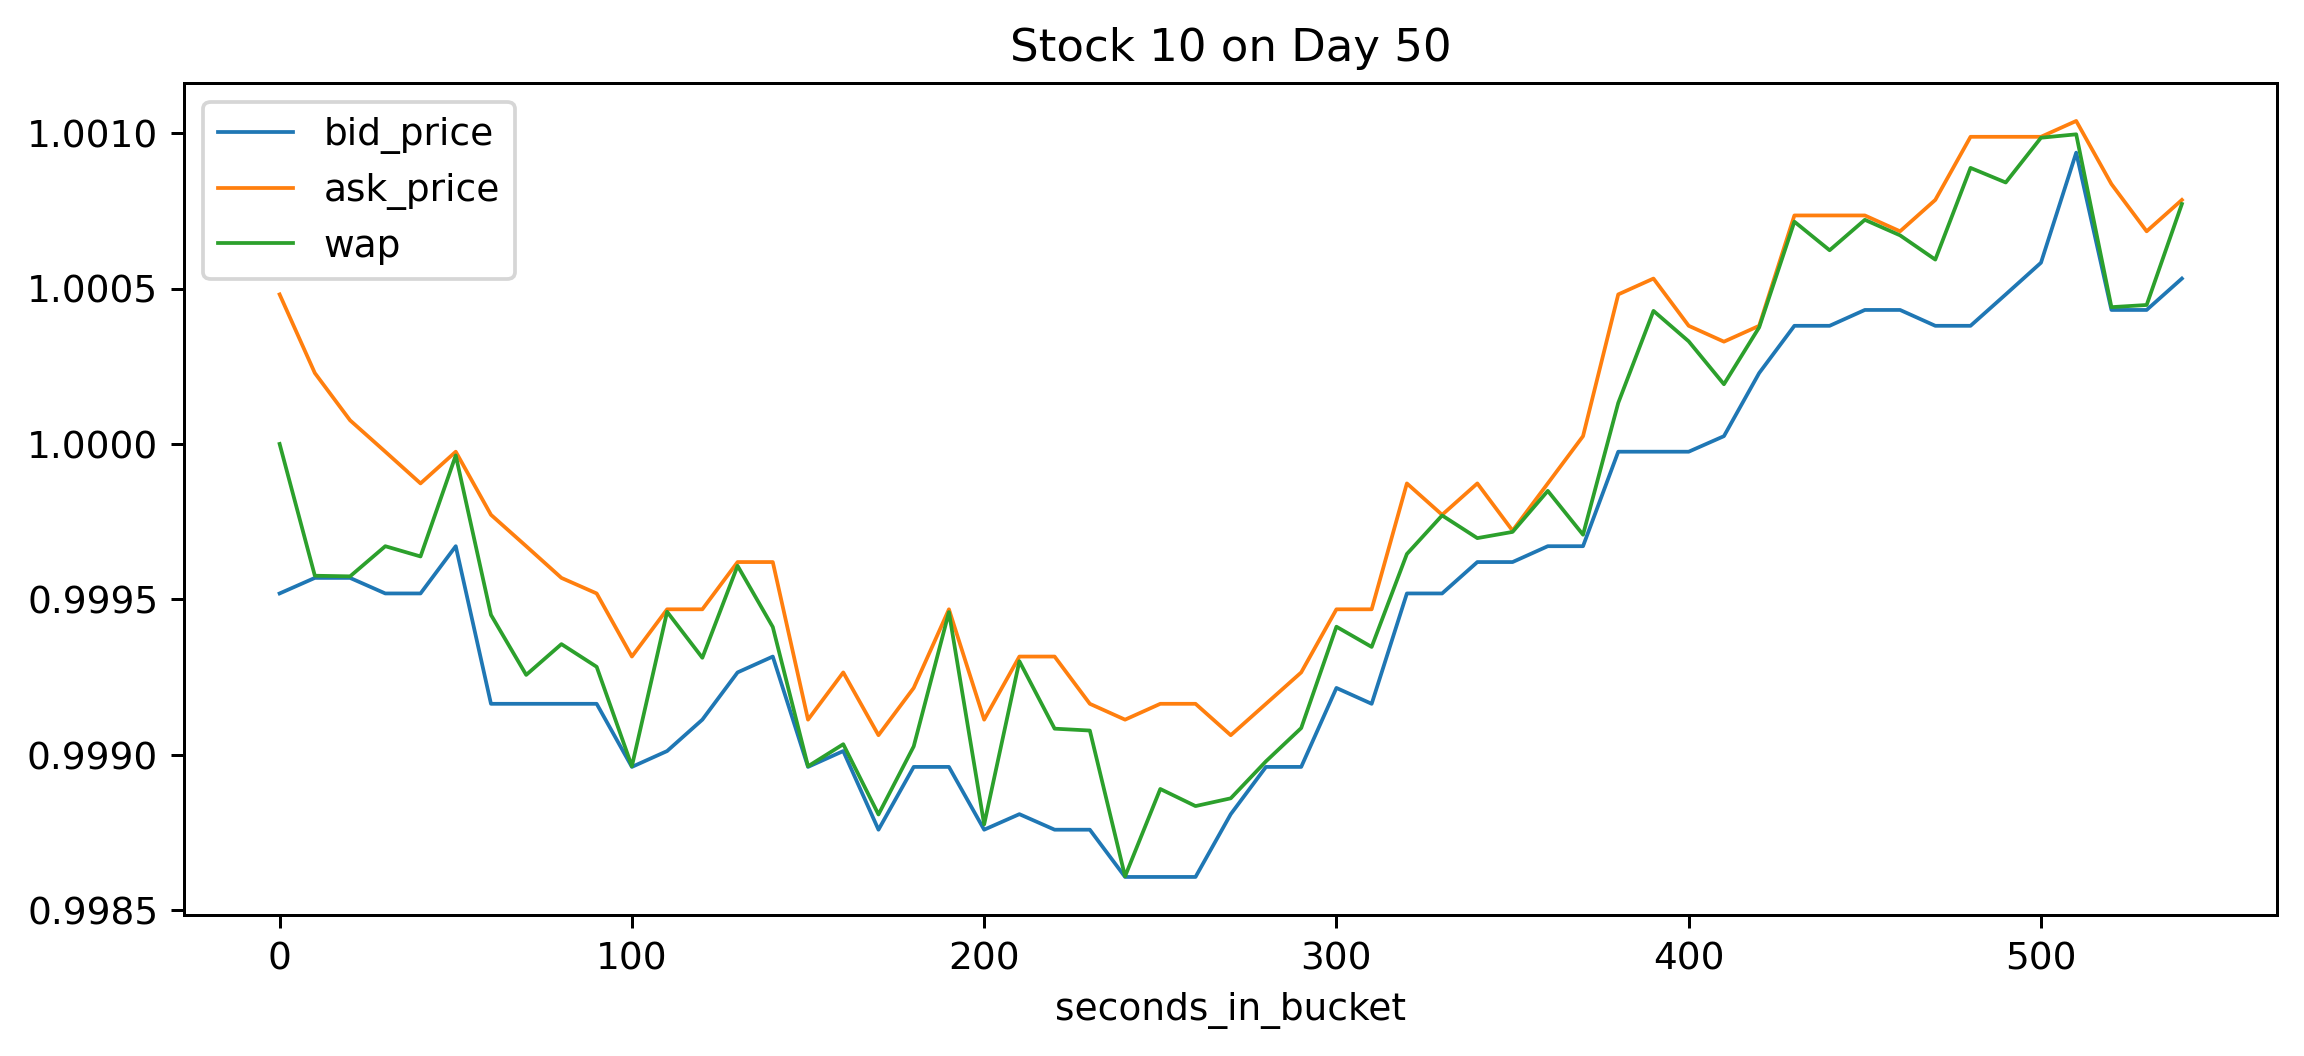

In [16]:
# 绘制bid_price, ask_price和 wap的图像
time_series_plot(
    df=Xy_Train, 
    cols=['bid_price','ask_price', 'wap'], 
    stock_id = 10,
    date_id = 50
)

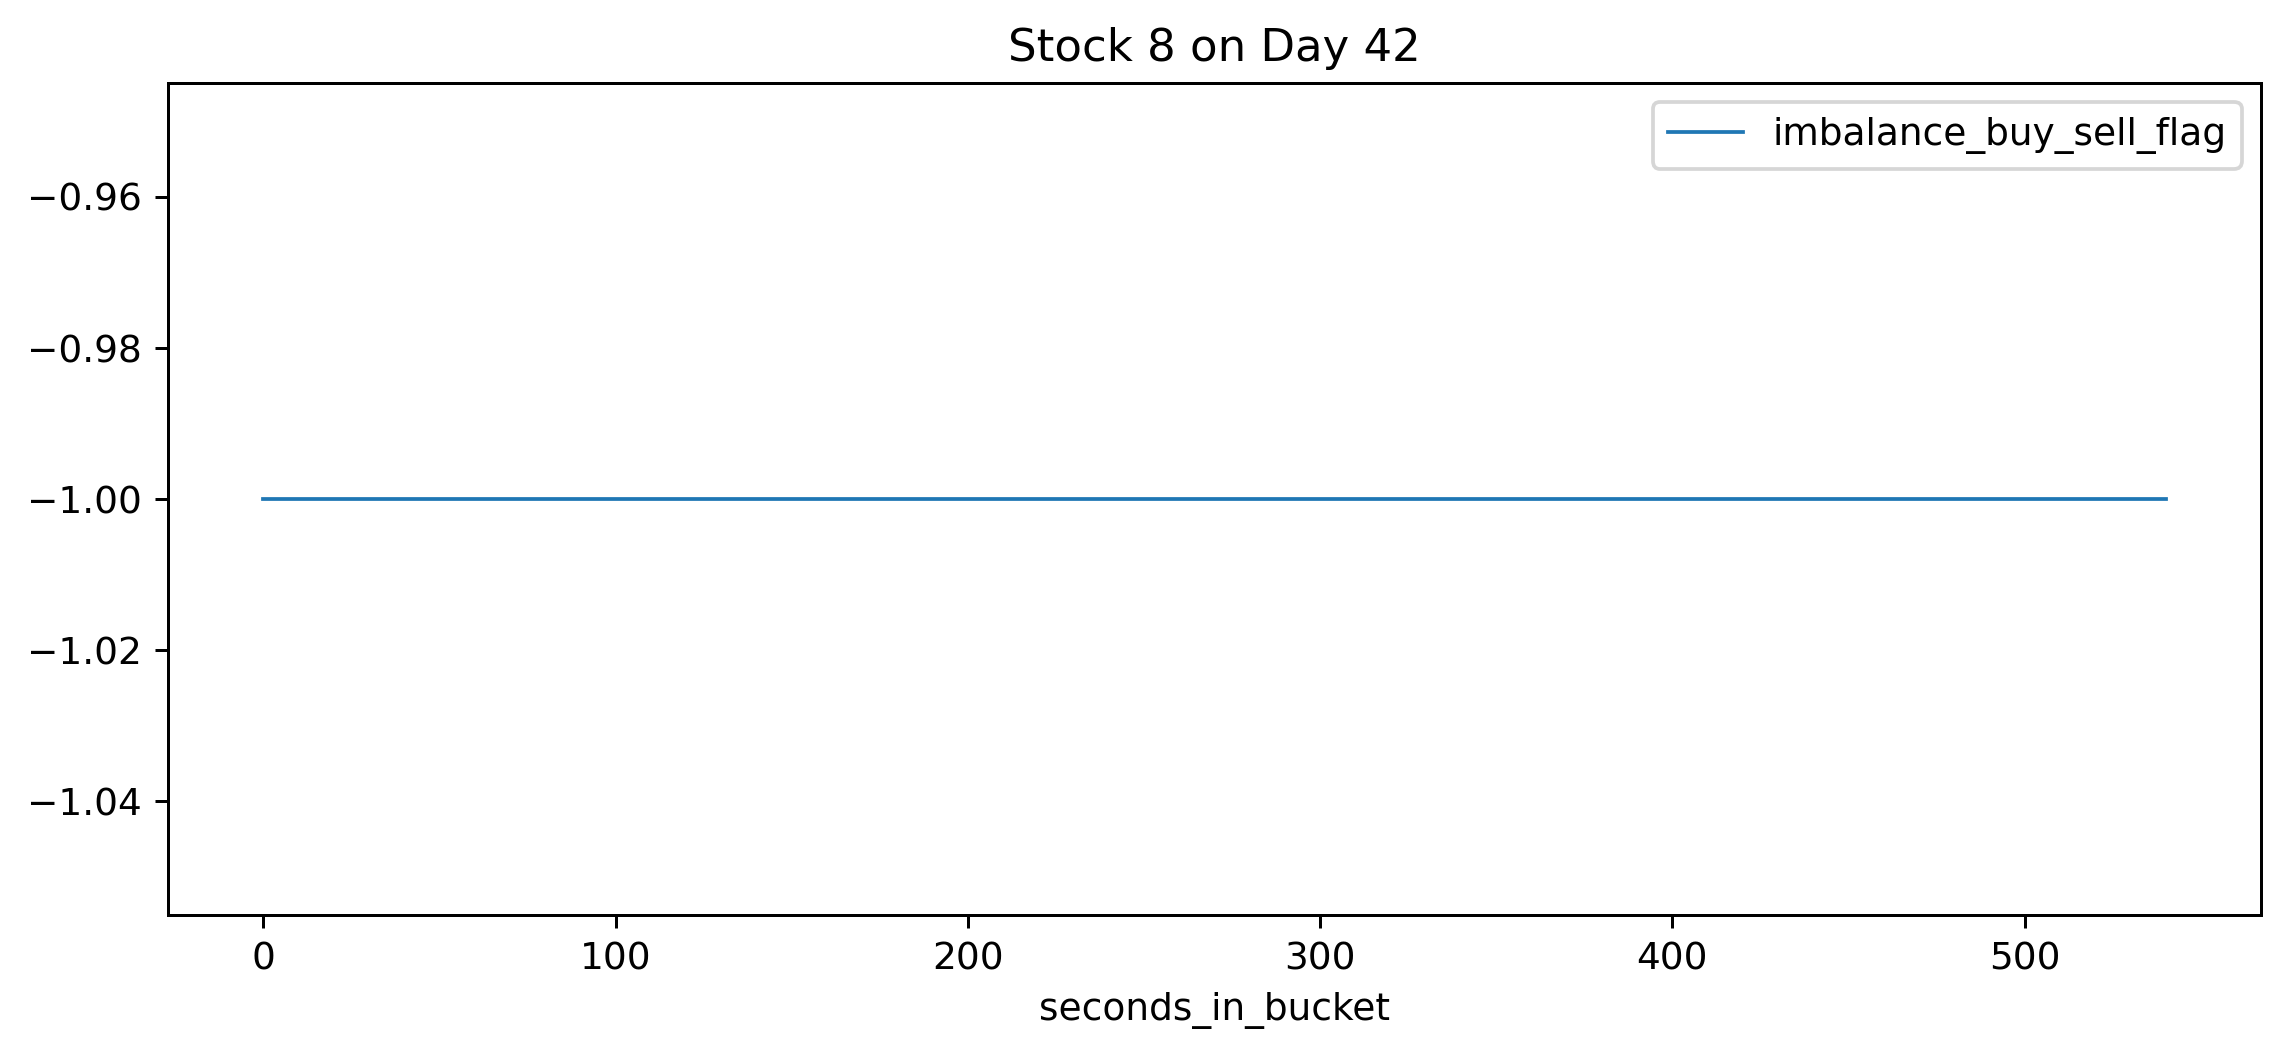

In [17]:
# 观测imbalance_buy_sell_flag的变化
time_series_plot(
    df=Xy_Train, 
    cols=['imbalance_buy_sell_flag'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

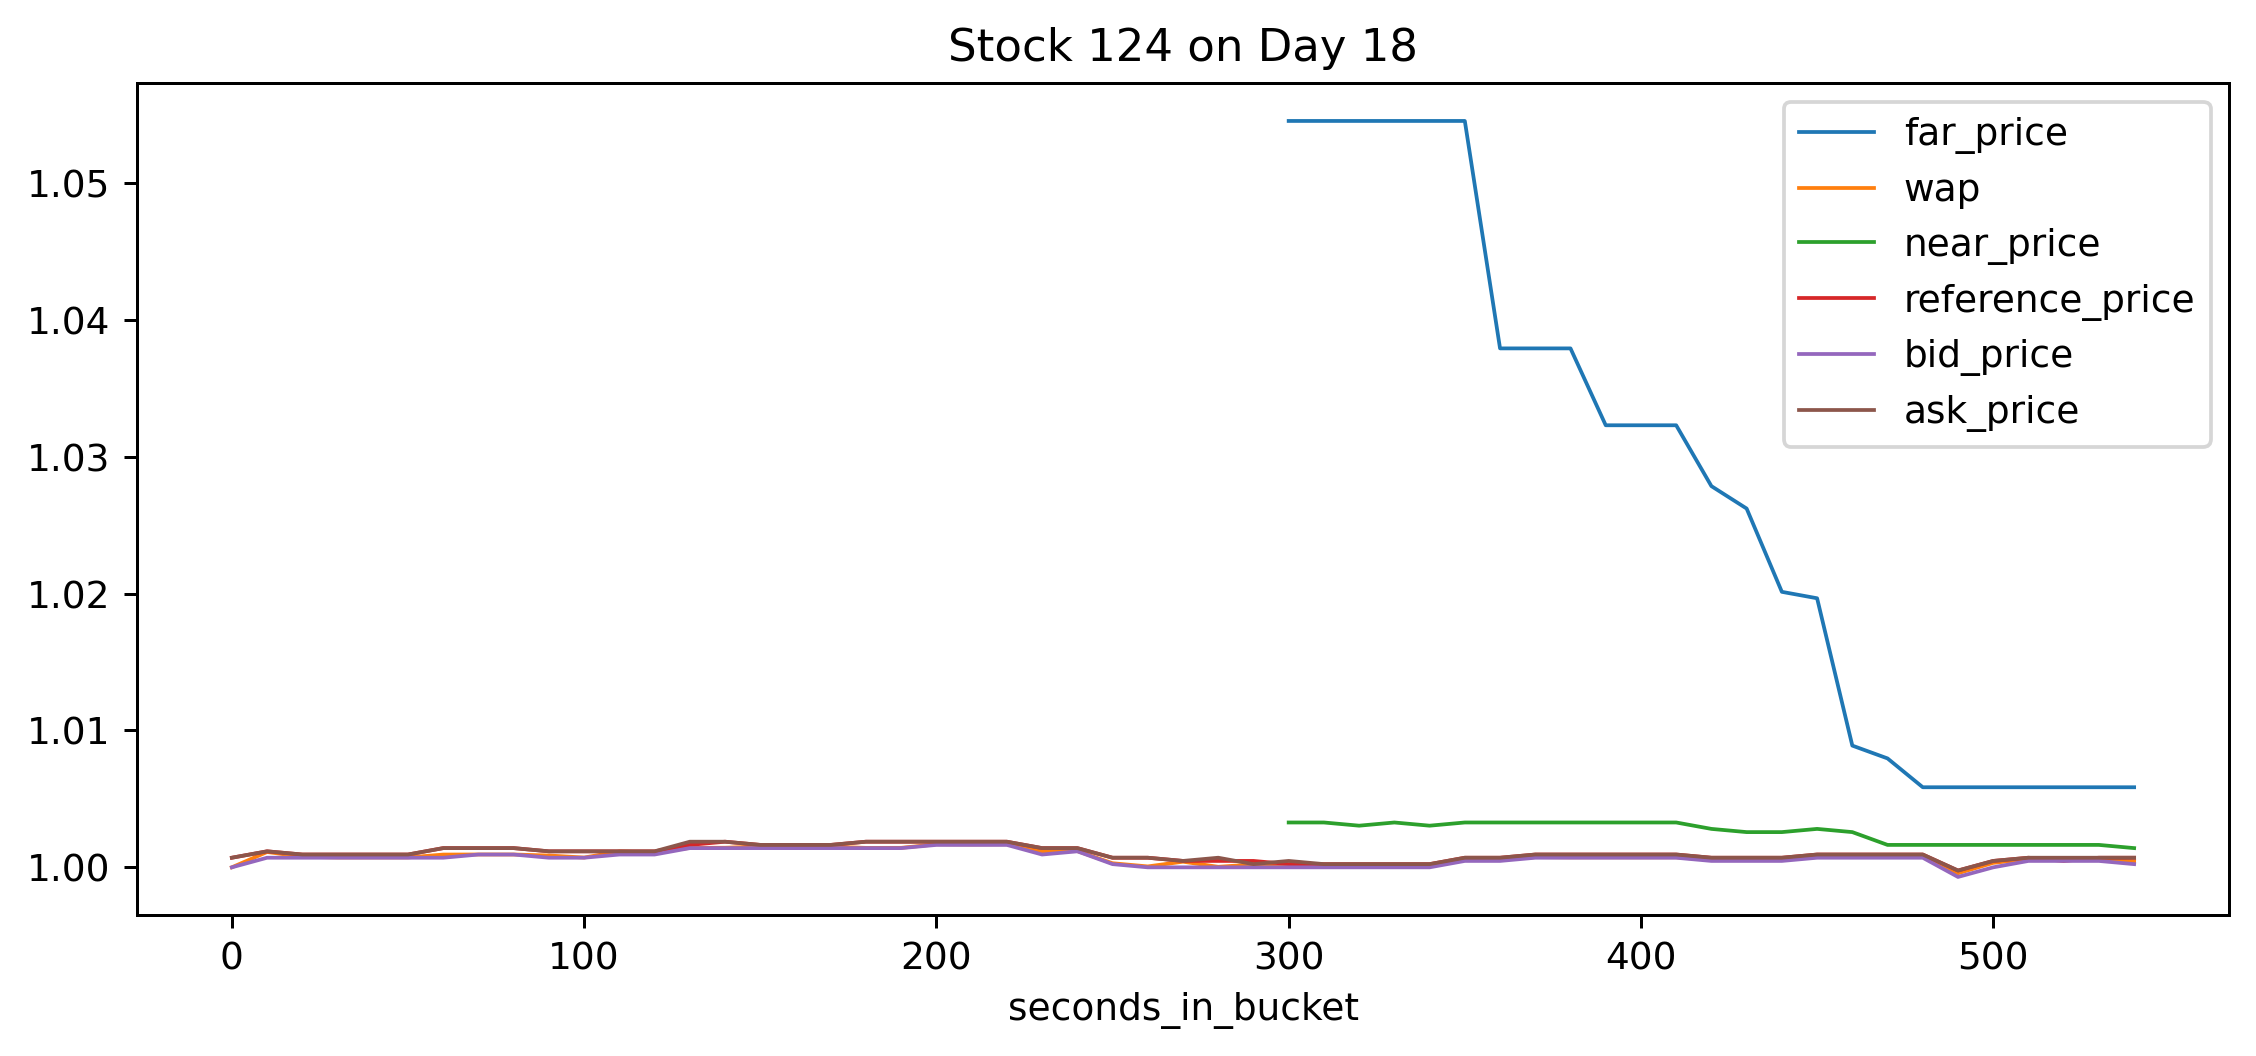

In [18]:
# 对比六个价格数据
time_series_plot(
    df=Xy_Train, 
    cols=['far_price', 'wap', 'near_price', 'reference_price', 'bid_price', 'ask_price'],
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

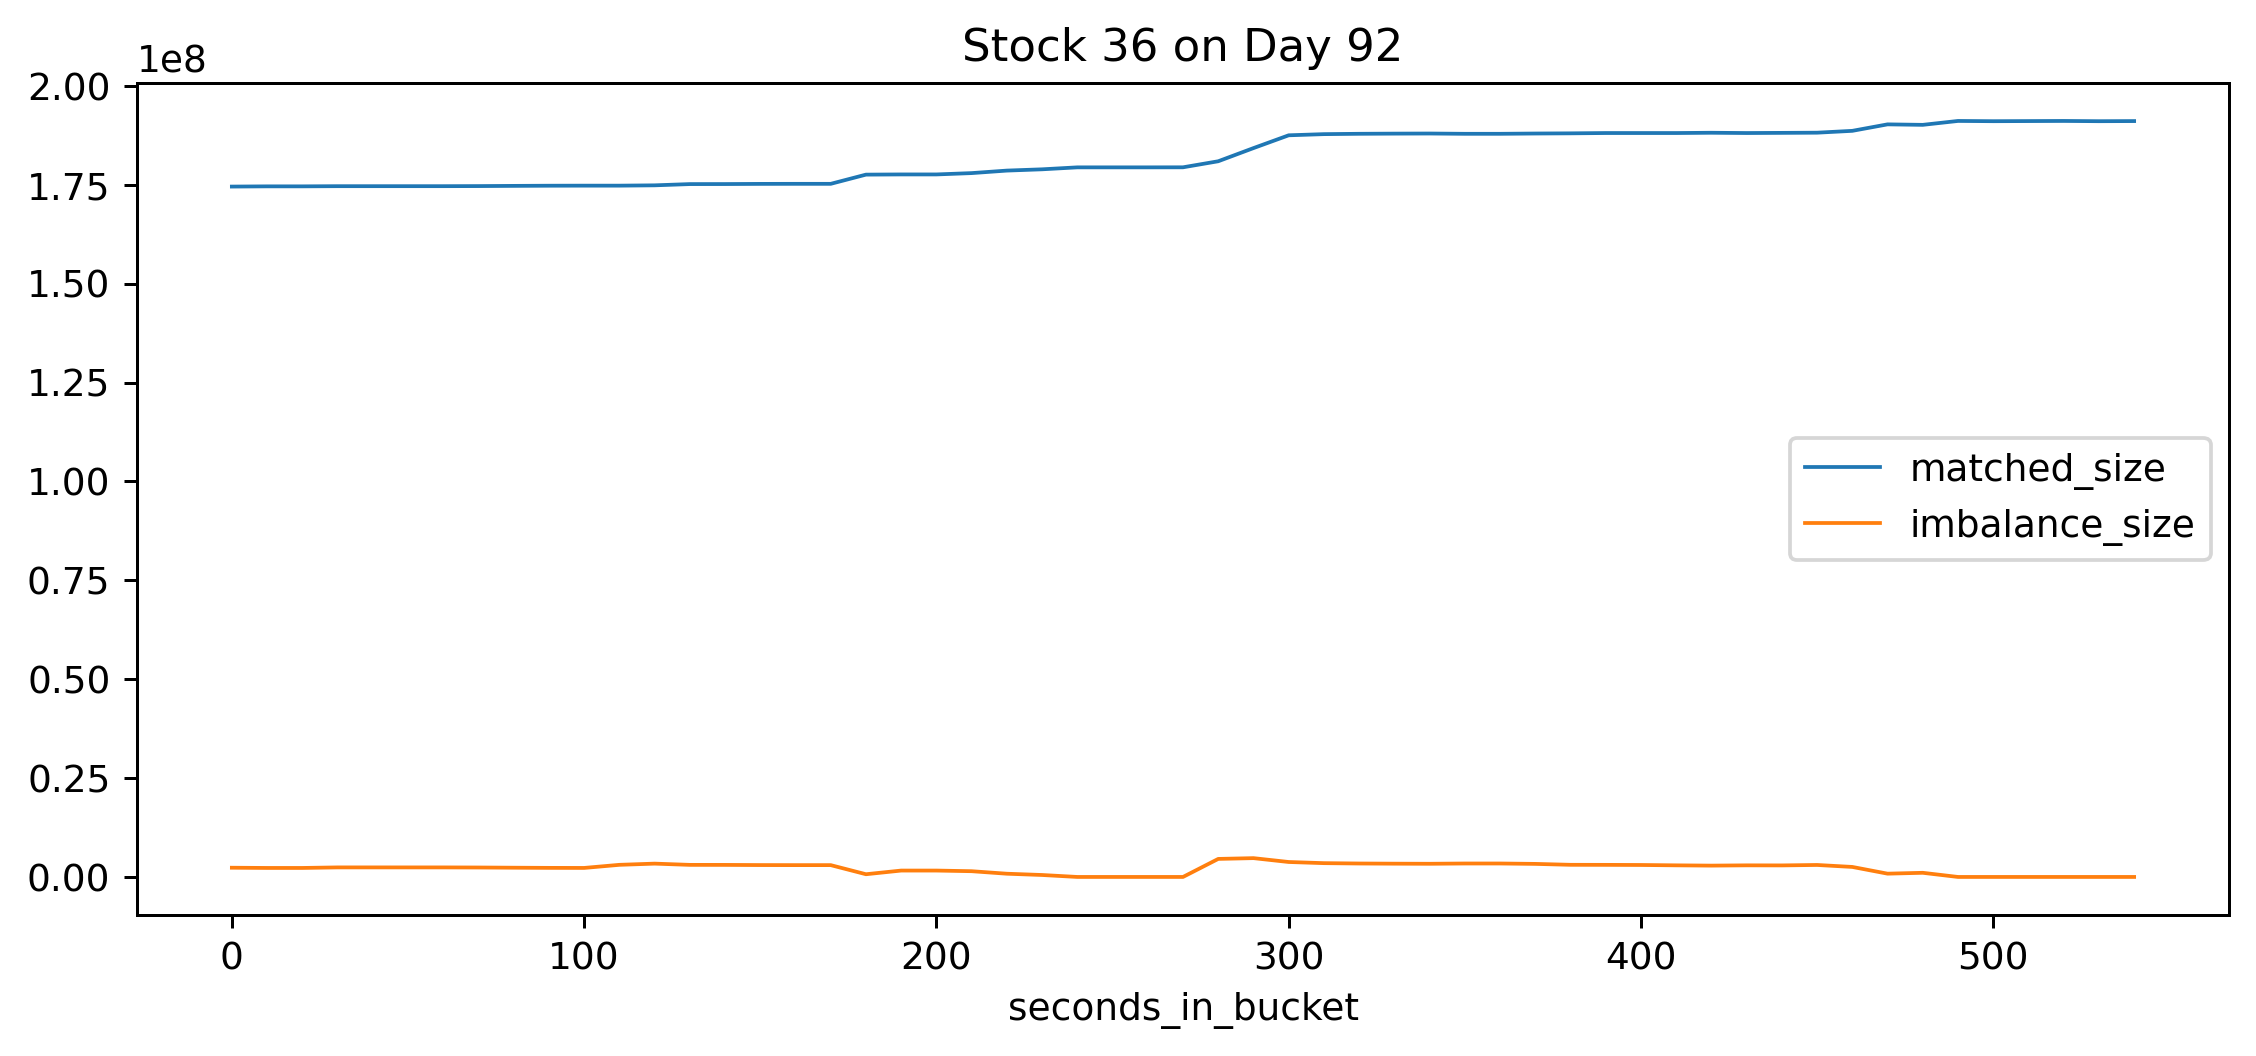

In [19]:
# 对比match_size和imbalance_size
time_series_plot(
    df=Xy_Train, 
    cols=['matched_size', 'imbalance_size'], 
    stock_id = np.random.randint(low=0, high=200), 
    date_id = np.random.randint(low=0, high=480),
)

### 预测目标
- 预测的目标是每个stock_id在date_id下对应的seconds_in_bucket之后60s的WAP（相对于综合指数WAP的超额）
$$
Target = (\frac{StockWAP_{t+60}}{StockWAP_t} - \frac{IndexWAP_{t+60}}{IndexWAP_t})
$$
- 由于整个的预测目标是个连续值，因此应该采用回归的预测方法

In [20]:
# describe the target
label = Xy_Train[['stock_id', 'date_id', 'seconds_in_bucket', 'target', 'row_id']].dropna()
# 调查样本对称情况，看四阶矩
print(f"Mean: {label.target.mean()}\nStd: {label.target.std()}\nSkew: {label.target.skew()}\nKurt: {label.target.kurt()}")
# 均值几乎为0，偏度也几乎为0，因此可以看作是对称的
label.target.describe()

Mean: -0.04756124560789285
Std: 9.452859686758666
Skew: 0.20466880279847177
Kurt: 22.557970029731255


count    5.238e+06
mean    -4.756e-02
std      9.453e+00
min     -3.853e+02
25%     -4.560e+00
50%     -6.020e-02
75%      4.410e+00
max      4.461e+02
Name: target, dtype: float64

In [21]:
# 检查离群点和极端值
up_line = label.target.mean() + 3 * label.target.std()
bottom_line = label.target.mean() - 3 * label.target.std()
trimmed_data = label.target[(label.target >= bottom_line) & (label.target <= up_line)]
outlier = label.target[(label.target < bottom_line) | (label.target > up_line)]
print(f"Outlier's num: {outlier.count()}, Proportion: {outlier.count() / label.target.count()}")
trimmed_data.describe()

Outlier's num: 77975, Proportion: 0.014886713968138328


count    5.160e+06
mean    -7.494e-02
std      7.914e+00
min     -2.840e+01
25%     -4.480e+00
50%     -6.974e-02
75%      4.320e+00
max      2.831e+01
Name: target, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


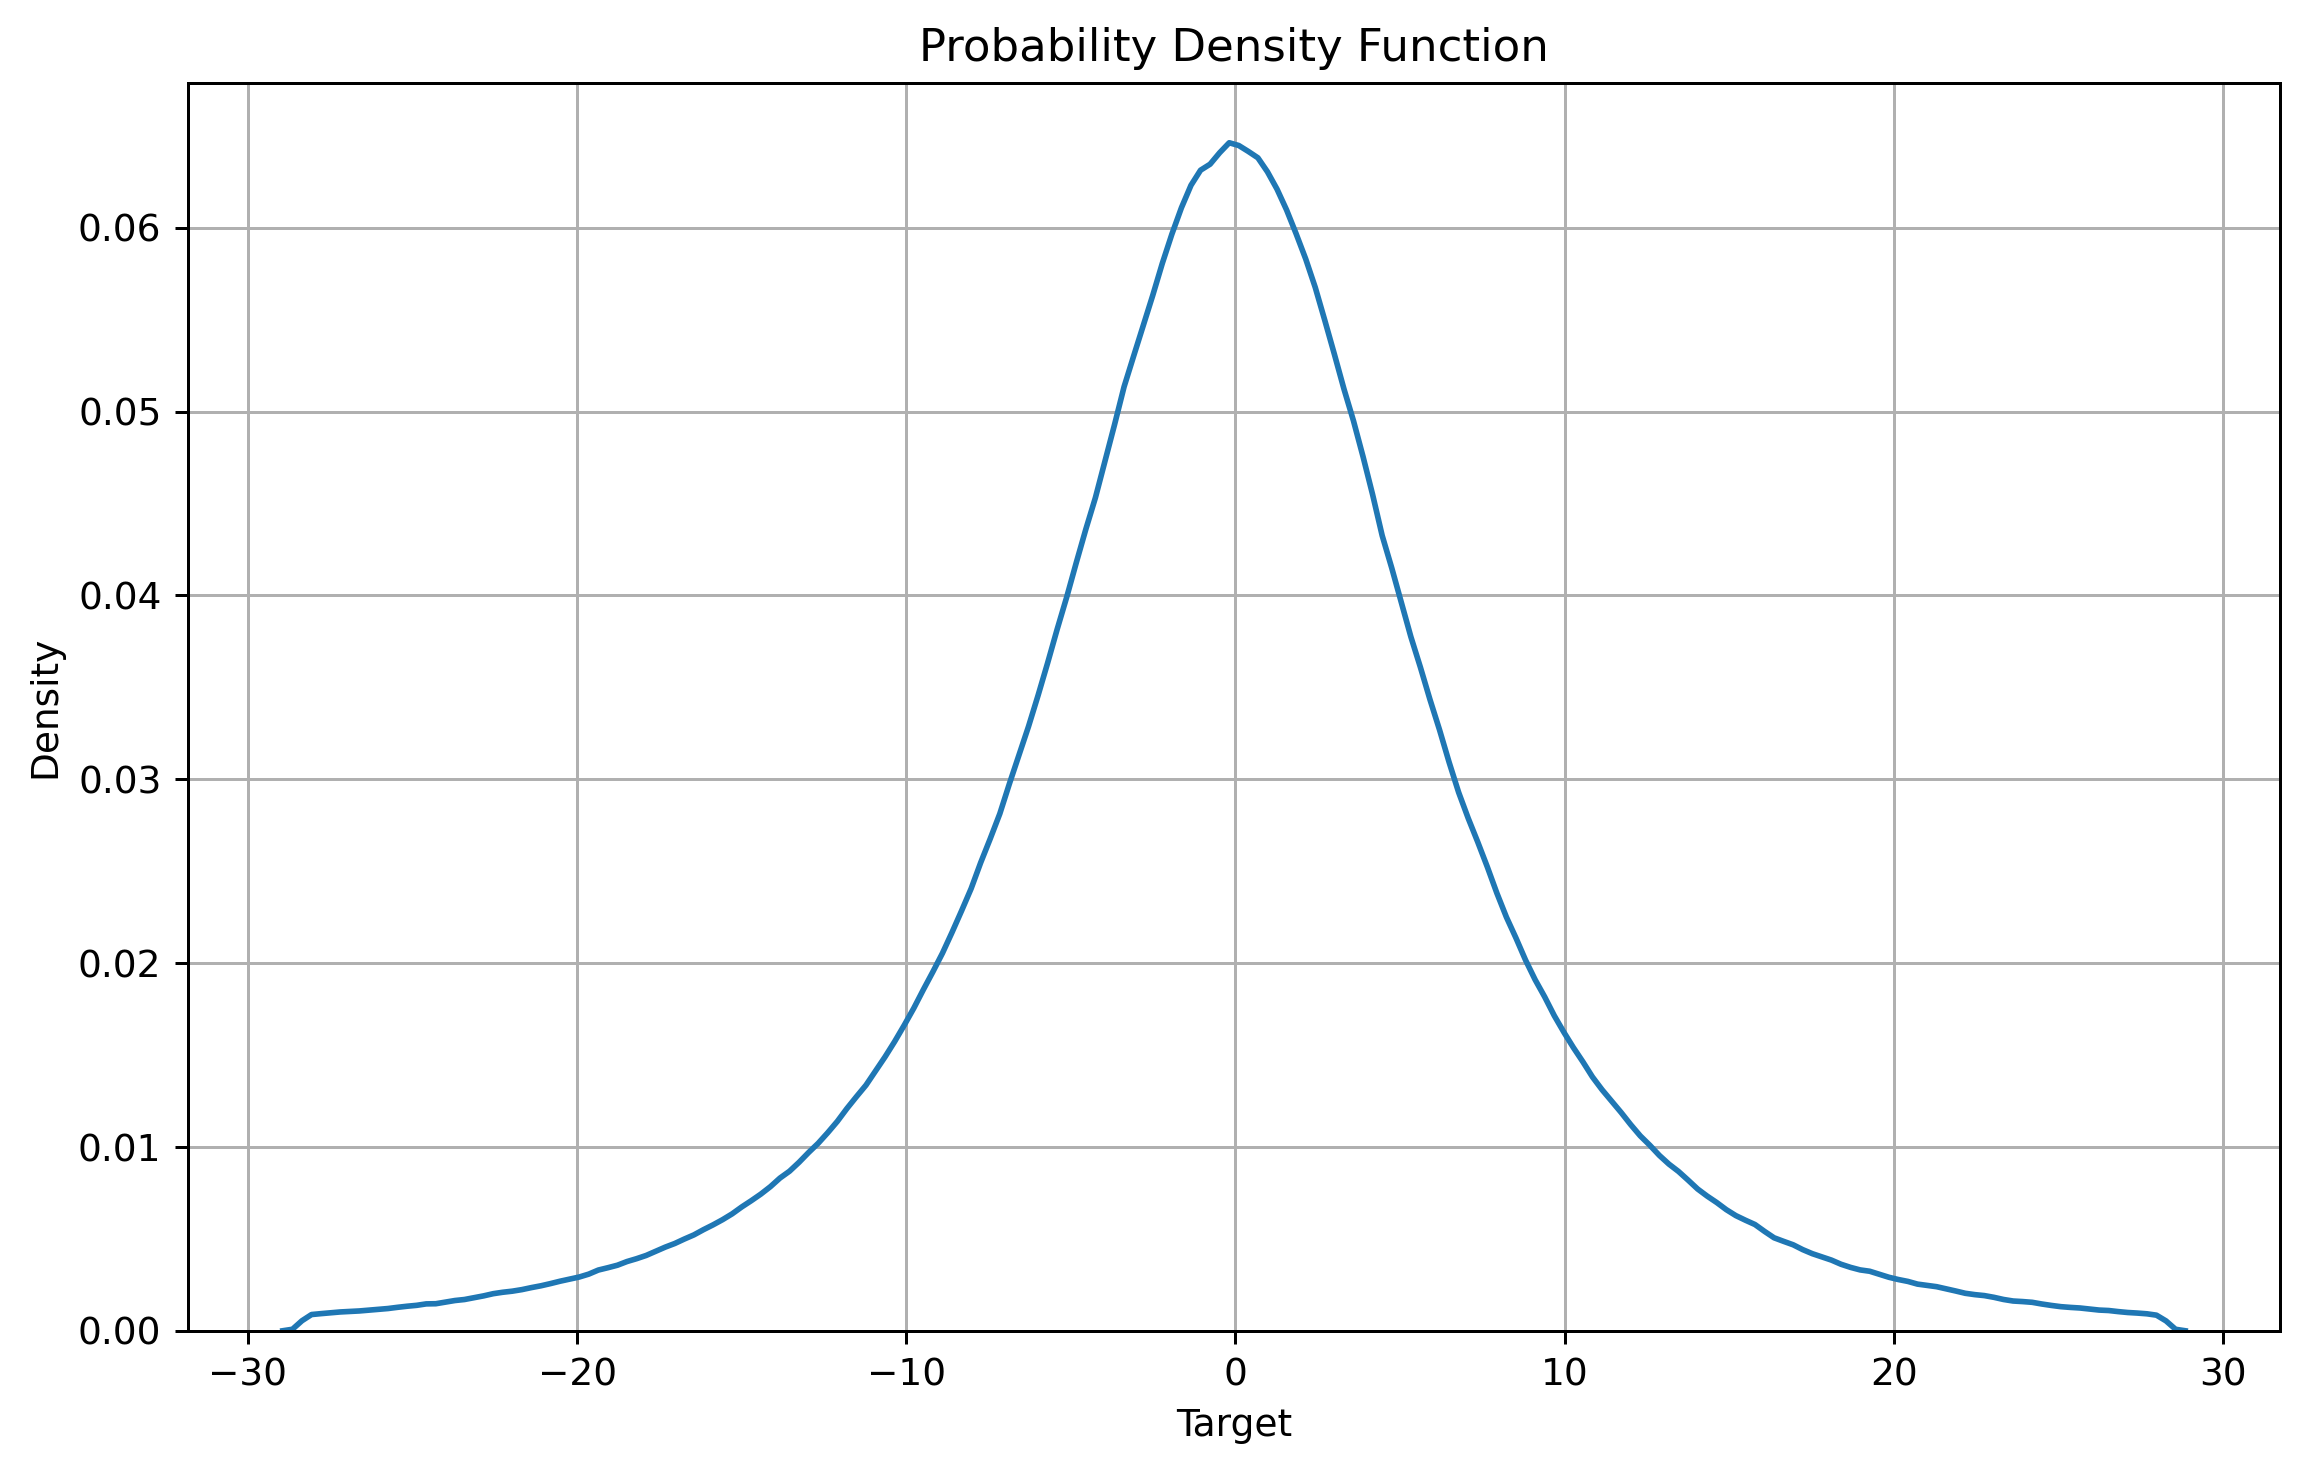

In [22]:
plt.figure(figsize=(10, 6))
sns.kdeplot(trimmed_data, bw_adjust=0.5)
plt.title('Probability Density Function')
plt.xlabel('Target')
plt.ylabel('Density')
plt.grid()
plt.show()

去掉极端值的分布整体看来还是比较对称的，后续可以考虑将去除极端值的target来进行训练？

## BaseLine（LightGBM）

In [23]:
# We split the data here, and use them in the following sections

X_Train = Xy_Train.query("target.notna()").drop(['row_id', "time_id"], axis=1)
X_Train = X_Train.dropna(how='any', axis=0)
y_Train = X_Train.pop("target")
print(X_Train.shape)

(2343638, 14)


In [24]:
estimator = lgb.LGBMRegressor(
    boosting_type='gbdt', 
    num_leaves=31, 
    max_depth=-1, 
    learning_rate=0.1, 
    n_estimators=100, 
    subsample_for_bin=200000, 
    objective='mae', 
    class_weight=None, 
    min_split_gain=0.0, 
    min_child_weight=0.001, 
    min_child_samples=20, 
    subsample=1.0, 
    subsample_freq=0, 
    colsample_bytree=1.0, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    random_state=1207, 
    n_jobs=-1, 
    importance_type='split',
    force_row_wise=True
)

val_predictions = np.zeros(len(X_Train))
val_scores = []

splitter = sk.model_selection.TimeSeriesSplit(5).split(X_Train, y_Train)

for fold, (train_idx, val_idx) in enumerate(splitter):
    model = sk.base.clone(estimator)

    # Define train and val set
    X_train = X_Train.iloc[train_idx]
    y_train = y_Train.iloc[train_idx]
    X_val = X_Train.iloc[val_idx]
    y_val = y_Train.iloc[val_idx]

    model.fit(X_train, y_train)
    val_scores.append(sk.metrics.mean_absolute_error(model.predict(X_val), y_val))

print(f'Val Score: {np.mean(val_scores):.2f} ± {np.std(val_scores):.5f}')

[LightGBM] [Info] Total Bins 2858
[LightGBM] [Info] Number of data points in the train set: 390608, number of used features: 14
[LightGBM] [Info] Total Bins 2940
[LightGBM] [Info] Number of data points in the train set: 781214, number of used features: 14
[LightGBM] [Info] Start training from score -0.050068
[LightGBM] [Info] Total Bins 3021
[LightGBM] [Info] Number of data points in the train set: 1171820, number of used features: 14
[LightGBM] [Info] Start training from score -0.060201
[LightGBM] [Info] Total Bins 3025
[LightGBM] [Info] Number of data points in the train set: 1562426, number of used features: 14
[LightGBM] [Info] Start training from score -0.029802
[LightGBM] [Info] Total Bins 3028
[LightGBM] [Info] Number of data points in the train set: 1953032, number of used features: 14
[LightGBM] [Info] Start training from score -0.039935
Val Score: 5.80 ± 0.51700


In [27]:
import optiver2023

env = optiver2023.make_env()
iter_test = env.iter_test()

model.fit(X_Train, y_Train)

# 保存模型
with open('/kaggle/working/model.pkl', 'wb') as f:
    pickle.dump(model, f)

# 加载模型
# with open('/kaggle/working/model.pkl', 'rb') as f:
#     model = pickle.load(f)

counter = 0
for (test, revealed_targets, sample_prediction) in iter_test:
    sample_prediction['target'] = model.predict(test.iloc[:, :-1].drop('row_id', axis = 1))
    env.predict(sample_prediction)
    counter += 1

[LightGBM] [Info] Total Bins 3032
[LightGBM] [Info] Number of data points in the train set: 2343638, number of used features: 14
[LightGBM] [Info] Start training from score -0.039935
This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [28]:
sample_prediction

,row_id,target
0,480_540_0,-0.492
1,480_540_1,0.076
2,480_540_2,-0.110
3,480_540_3,-0.937
4,480_540_4,-0.606
...,...,...
195,480_540_195,-0.958
196,480_540_196,-1.249
197,480_540_197,-0.435
198,480_540_198,1.902
